# The HFM library - A fast marching solver with adaptive stencils 

## Part : Algorithmic enhancements to the fast marching method
## Chapter : Sensitivity in semi-Lagrangian schemes

The HFM library provides a variety of metric classes : isotropic, Riemannian, Rander, asymmetric quadratic, defined by a Hooke tensor, and more. With the exception of isotropic metrics they depend on multiple parameters.

Automatic differentiation is more complex with anisotropic metrics, and requires specific computational techniques, for which we can only provide limited support. We illustrate here their foundations and usage.
For that purpose, we distinguish cases depending on an implementation detail that is usually transparent to the user.

**Eulerian vs Semi-Lagrangian schemes.**
The HFM (Hamiltonian Fast Marching) library takes its name from a family of Eulerian schemes based on a specific representation of the Hamiltonian, which are particularly efficient for Riemannian metrics and curvature penalized metrics, see:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

However, other classes of metrics (such as Rander, asymmetric quadratic, or hooke tensor defined), require a different approach. In their case, we rely on an adaptive semi-Lagrangian scheme, in the spirit of 
* Mirebeau, J.-M. (2014). Efficient fast marching with Finsler metrics. Numerische Mathematik, 126(3), 515–557. [link](https://hal.archives-ouvertes.fr/hal-00736431)

**Semi-Lagrangian schemes** are discretizations of the eikonal equation 
$$
    F_x^*(\nabla u(x)) = 1
$$
in the following form which is closely related with Bellman's optimality principle
$$
    u(x) = \min_{y \in S(x)} F_x(x-y) + I_{S(x)} u(y),
$$
where $S(x)$ the *stencil* is a polygonal neighborhood of $x$ whose vertices are grid-points, and $I_S$ denotes piecewise linear interpolation.
The equality is imposed at all points of the discrete or continuous domain. In addition, adequate boundary conditions are imposed on the domain boundary, usually of Dirichlet and of outflow type.

**The geodesic flow.**
The minimizer $y_*(x) \in S(x)$ in the semi-lagrangian discretization of the eikonal equation has a geometrical interpretation: $v_*(x) = x-y_*(x)$ approximates the direction of the minimal geodesic passing through $x$, referred to as the geodesic flow direction. This data it is optionally exported by the HFM library, after normalization, under the name `geodesicFlow`.

<!---
Said otherwise, one has $V(x) \approx v_*$, where 
$$
    \gamma'(t) = V(\gamma(t)) \quad V(x) = \nabla F_x^*(\nabla u(x))
$$
--->

**The envelope theorem.**
Under suitable assumptions, one can differentiate the value of an optimization problem w.r.t. parameters, using the so-called envelope theorem: the extremizer variation can be ignored at first order.

Said otherwise, if the metric depends on a small parameter $\epsilon$, then
$$
    u(x;\epsilon) = F_x(v_*(x);\epsilon) + I_{S(x)}u(y_*(x);\epsilon) + o(\epsilon).
$$

As a result, if two parameter dependent metrics $F$ and $G$ obey
$$
    F_x(v_*(x); \epsilon) = G_x(v_*(x); \epsilon) + o(\epsilon),
$$
at all discretization points $x$, then they produce identical first order perturbations of $u$.
The HFM library takes advantage of this fact to simplify computations, but for that purposes needs the geodesic flow direction $v_*(x)$ to be computed in a preliminary step.

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Forward differentiation](#1.-Forward-differentiation)
    * [1.1 Isotropic example](#1.1-Isotropic-example)
    * [1.1 Rander example](#1.1-Rander-example)
  * [2. Reverse differentiation](#2.-Reverse-differentiation)
    * [2.1 Isotropic example](#2.1-Isotropic-example)
    * [2.2 Rander example](#2.2-Rander-example)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [34]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('SensitivitySL','FMM'))

In [35]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import FiniteDifferences as fd
from agd import Metrics
from agd import LinearParallel as lp
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Sensitivity'

In [36]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.optimize

In [37]:
def reload_packages():
    from importlib import reload
    HFMUtils = reload(sys.modules['agd.HFMUtils'])
    HFMUtils.reload_submodules()
    fd = reload(sys.modules['agd.FiniteDifferences'])
    Metrics = reload(sys.modules['agd.Metrics'])
    Metrics.reload_submodules()
    ad = reload(sys.modules['agd.AutomaticDifferentiation'])
    ad.reload_submodules()
    lp = reload(sys.modules['agd.LinearParallel'])

## 1. Forward differentiation

We illustrate forward differentiation of anisotropic fast marching, with Rander metrics.
Note that isotropic and Riemannian metrics are special cases of Rander metrics, hence the method presented below extends to those using appropriate casts. And this is indeed what we do in the next subsection.

<!---**Note** The default numerical schemes for the models 'Isotropic2' and 'Riemann2' do not --->

### 1.1 Isotropic example

We use a Rander metric to encode an isotropic metric, so as to illustrate the semi-Lagrangian discretization and its automatic differentiation.

In [38]:
hfmIn = HFMUtils.dictIn({
    'model':'Rander2',
    'arrayOrdering':'RowMajor',
    'seeds':[[0,0]],
    'extractValues':True,
})
hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=100)
X = np.array(hfmIn.Grid())

delta = ad.Dense.identity((1,))
metric =  Metrics.Isotropic(1.+delta[0],vdim=2)
#metric = Metrics.Riemann.from_diagonal(1.+delta[0],1.+delta[0]) #Alternatively

As described above, automatic differentiation in the semi-Lagrangian setting is a two-step process.

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.147076 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


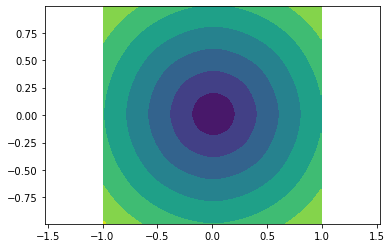

In [39]:
hfmIn['metric'] = metric
hfmOut_ad,values_ad = hfmIn.RunSmart()
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0)); 

The caching of the geodesicflow could be done manually.

--- First run for caching geodesic flow information ---
Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.148542 s.
Filling cache data
--- Second run using cached data :  dict_keys(['values', 'activeNeighs', 'geodesicFlow'])  ---
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


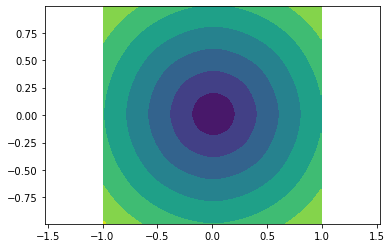

In [40]:
print("--- First run for caching geodesic flow information ---")
hfmIn_noad = hfmIn.copy()
hfmIn_noad['metric'] = ad.remove_ad(metric,iterables=(Metrics.Base,))
cache = HFMUtils.Cache(needsflow=True)
hfmIn_noad.RunSmart(cache=cache)

print("--- Second run using cached data : ", cache.contents.keys()," ---")
hfmOut_ad,values_ad = hfmIn.RunSmart(cache=cache)
plt.axis('equal')
plt.contourf(*X,values_ad.gradient(0));

### 1.1 Rander example

Rander metrics are a generalization of Riemannian metrics, involving an additional asymmetric part. 
In particular, any Riemannian metric can be cast into a Rander metric, which allows to use automatic differentiation in this context. We reproduce an instance of Zermelo's navigation problem under a drift, which involves a Rander metric, see notebook [Rander](Rander.ipynb)

In [41]:
R = np.linalg.norm(X,axis=0)
driftMult = 0.9*np.sin(2*np.pi*X[0])*np.sin(2.*np.pi*X[1])
drift = (driftMult/R) * X
zermelo = Metrics.Rander.from_Zermelo(np.eye(2),drift)

Independent perturbations are applied to the symmetric and antisymmetric part of the metric.

In [42]:
delta = ad.Dense.identity(shape=(3,))
zermelo_ad = Metrics.Rander(zermelo.m *( 1 + delta[0]*(X[0]>2*X[1]) + delta[1]*(X[0]<=2*X[1]) ), 
                            zermelo.w*(1+delta[2]) )

In [43]:
hfmIn['metric']=zermelo_ad
hfmOut,values = hfmIn.RunSmart()
values_zermelo_forward = values

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.189153 s.
--- HFM call triggered above to compute geodesic flow ---
Filling cache data
Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


We rely on Euler's identity for validation, which implies here that a weighted sum of the chosen perturbations equals the distance map.

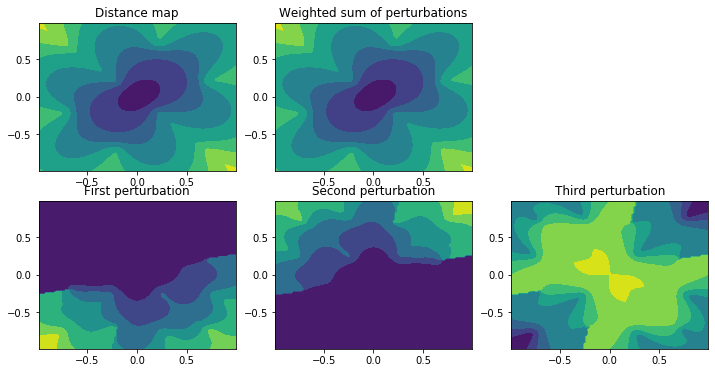

In [44]:
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.title('Distance map')
plt.contourf(*X,values.value)
plt.subplot(2,3,2)
plt.title('Weighted sum of perturbations')
plt.contourf(*X,2*values.gradient(0)+2*values.gradient(1)+values.gradient(2));
plt.subplot(2,3,4)
plt.title('First perturbation')
plt.contourf(*X,values.gradient(0))
plt.subplot(2,3,5)
plt.title('Second perturbation')
plt.contourf(*X,values.gradient(1))
plt.subplot(2,3,6)
plt.title('Third perturbation')
plt.contourf(*X,values.gradient(2));

## 2. Reverse differentiation 

We reproduce and validate the previous examples using reverse automatic differentiation, which allows the efficient computation of the gradient of an objective function defined in terms of the output values of fast marching method, w.r.t. each component of the input metric.

### 2.1 Isotropic example

In [45]:
cost = np.ones(hfmIn['dims'].astype(int))
rev,cost_ad = ad.Reverse.empty(inputs=cost,input_iterables = (dict,Metrics.Base))
metric_ad =  Metrics.Isotropic(cost_ad)
hfmIn['metric'] = metric_ad

In [46]:
hfmOut,values_ad = rev.apply(HFMUtils.RunSmart,hfmIn,cache=HFMUtils.Cache())

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.170795 s.
Field exportGeodesicFlow defaults to 0
Filling cache data


In [47]:
interp = fd.UniformGridInterpolator(X,values_ad)
x0 = (0.2,0.8); x1 = (-0.5,-0.9); alpha0 = 1.2; alpha1 = 0.7
objective = alpha0*interp(*x0)+alpha1*interp(*x1)

In [48]:
grad, = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


The support of the gradient approximates the geodesics, which in the case of a constant metric are straight lines.

The support of the gradient


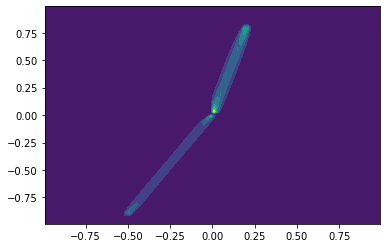

In [49]:
print("The support of the gradient")
plt.contourf(*X,grad);

### 2.2 Rander example

We reproduce Zermelo's navigation problem presented in the first section, and cross validate the forward and reverse automatic differentiation methods.

In [50]:
rev,zermelo_rev = ad.Reverse.empty(inputs=zermelo,input_iterables = (dict,Metrics.Base))
hfmIn['metric'] = zermelo_rev

In [51]:
hfmOut,values_ad = rev.apply(HFMUtils.RunSmart,hfmIn,cache=HFMUtils.Cache())

Requesting cacheable data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Fast marching solver completed in 0.188382 s.
Field exportGeodesicFlow defaults to 0
Filling cache data


In [52]:
interp = fd.UniformGridInterpolator(X,values_ad)
objective = alpha0*interp(*x0)+alpha1*interp(*x1)

In [53]:
grad_m,grad_w = rev.to_inputshapes(rev.gradient(objective))

Providing cached data
Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field refineStencilAtWallBoundary defaults to 0
Field order defaults to 1
Field spreadSeeds defaults to -1
Field showProgress defaults to 0
Field factoringMethod defaults to None
Bypassing fast marching solver based on cached data.


We validate the results by comparing forward and reverse automatic differentiation, of the above objective function, with the above variations in the Rander metric.

In [54]:
[ (grad_m*zermelo_ad.m.gradient(i)).sum() + (grad_w*zermelo_ad.w.gradient(i)).sum() for i in range(3)]

[0.6203401092107069, 0.6938514612990663, -0.8288951173454006]

In [55]:
interp = fd.UniformGridInterpolator(X,values_zermelo_forward)
(alpha0*interp(*x0)+alpha1*interp(*x1)).coef

array([ 0.62034011,  0.69385146, -0.82889512])